# Sarcasm Detection with FastAi

In this project, we are provided with a dataset that contains sarcastic comments from the Internet commentary website Reddit. The dataset was generated by scraping comments from Reddit containing the \s ( sarcasm) tag. This tag is often used by Redditors to indicate that their comment is in jest and not meant to be taken seriously, and is generally a reliable indicator of sarcastic comment content. 1 million comments from the Internet commentary website Reddit, half of which are actual sarcastic comments.

Here we present a model to detect sarcastic comments built using the deep learning library of FastAi based on recurrent neural network. The model is trained with about 1 million comments from the Internet commentary website Reddit, half of which are actual sarcastic comments. The dataset can be downloaded at https://www.kaggle.com/danofer/sarcasm#train-balanced-sarcasm.csv

## Setting up Google Colab to run the Notebook

In [0]:
 # to update fastai to the latest version
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
# to allow Colaboratory instance to read and write files to Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
print(base_dir)

/content/gdrive/My Drive/fastai-v3/


In [0]:
# Check python version
import sys
sys.version

'3.6.9 (default, Nov  7 2019, 10:44:02) \n[GCC 8.3.0]'

In [0]:
from fastai.text import *

In [0]:
# to check if gpu is enabled
torch.cuda.is_available()

True

In [0]:
# to check if gpu is enabled
torch.backends.cudnn.enabled

True

In [0]:
# for checking GPU assigned and available RAM

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print(gpu.name)
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=bbb6c99dbf18f7da357bc34f6d242dfcc8da995223a7b608f5804ef90961aaf3
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Tesla P100-PCIE-16GB
Gen RAM Free: 12.6 GB  | Proc size: 384.7 MB
GPU RAM Free: 16270MB | Used: 10MB | Util   0% | Total 16280MB


In [0]:
# pointing the path to the correct folder which contain the dataset
path = Path(base_dir + 'data/sarcasm')

In [0]:
path

PosixPath('/content/gdrive/My Drive/fastai-v3/data/sarcasm')

## Preparing the data

In [0]:
# loading the data into dataframe
df = pd.read_csv(path/'train-balanced-sarcasm.csv')
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [0]:
# checking for class labels and their numbers
df["label"].value_counts()

1    505413
0    505413
Name: label, dtype: int64

In [0]:
# checking for null comments
df.isna().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [0]:
# extract only the columns required
df = df[["label", "comment"]]

In [0]:
# removing rows with null comments
df = df.loc[~(df["comment"].isna())]

In [0]:
df.isna().sum()

label      0
comment    0
dtype: int64

In [0]:
df["label"].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [0]:
# splitting the dataframe into training and validation set
from sklearn.model_selection import train_test_split
train, valid = train_test_split(df, stratify=df["label"], random_state=2020, train_size=0.8)

In [0]:
train.shape

(808618, 2)

In [0]:
train["label"].value_counts()

0    404324
1    404294
Name: label, dtype: int64

In [0]:
valid.shape

(202155, 2)

In [0]:
valid["label"].value_counts()

0    101081
1    101074
Name: label, dtype: int64

In [0]:
# creating databunch from the images
data = TextDataBunch.from_df(path, train_df=train, valid_df=valid)

By executing this line a `TextDataBunch` is created to tokenize and numericalize the text.

In [0]:
data.save()

In [0]:
data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [0]:
data.show_batch()

text,target
xxbos * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc,0
xxbos xxup its * * xxup open xxup fucking xxup beta * * xxup people xxup holy xxup shit * * xxup open xxup beta * * xxup it xxup 's xxup still xxup being xxup worked xxup on xxup it xxup 's xxup in * * xxup open xxup beta * * xxup this xxup isn't xxup the xxup final xxup iteration xxup its xxup xxunk * * xxup,1
"xxbos i threw out an interesting scenario for the xxmaj magic , say you end up with xxmaj parker since the xxmaj sixers pick xxmaj exum to pair with xxup mcw since they want a two xxup pg system , so now you have a go to scorer , then trade a future pick along with xxmaj afflalo for pick 8 for xxmaj randle now you have an interior presence",0
"xxbos waited for two and a half hours to ride on the new xxmaj wicked xxmaj cyclone ride at xxmaj six xxmaj flags xxmaj new xxmaj england ( had a season pass , got early access ) ... then the ride broke down right as it was going to be my turn to get on ended up waiting another hour for them to fix it because * fuck it ,",0
"xxbos 2 states with high xxmaj asian and xxmaj native xxmaj american populations have voted , and both were caucuses ... seems like there 's not enough data to prove it false ( the caucus factor only really matters insofar as entrance polling for them seems to be pretty spotty ) and xxmaj bernie definitely is n't neutral with xxmaj latinos , he 's lost the xxmaj hispanic vote pretty",0


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [0]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [0]:
data.train_ds[0][0]

Text xxbos xxmaj leicester was xxunk

But the underlying data is all numbers

In [0]:
data.train_ds[0][0].data[:10]

array([    2,     5, 10360,    41,     0])

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
bs=32

We're not going to train a model that classifies the comments from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where we use the comments without their label first to fine-tune our model.

In [0]:
data_lm = TextLMDataBunch.from_df(path, train_df=train, valid_df=valid)

In [0]:
data_lm.save('data_lm.pkl')

We use `TextDataBunch` for the language model that ignores the labels of the comments

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [0]:
data_lm.show_batch()

idx,text
0,"costed though ! xxbos xxmaj why would xxmaj barry and xxmaj ross go as xxmaj holly and xxmaj ross ? xxbos because a nice camera takes nice pictures , you do nt . xxbos xxmaj normal xxmaj tuesday morning for xxmaj shia lebeouf xxbos xxmaj xxunk , xxmaj king of the xxmaj mole xxmaj people has spoken ! xxbos i get sad about a 9 - 1 record too ."
1,"in person that my girlfriend of 5 years had been cheating on me and gotten married behind my back while she was supposed to be going to college . xxbos xxmaj did you tell your niece there were 2 ? xxbos xxmaj sorry xxup axe , second place also is an awesome result xxup :p xxbos xxmaj but then i ca n't stand in patrol and farm blue engrams xxbos"
2,"though . xxbos xxmaj here here xxbos fuck my life xxbos xxup we xxup get a xxup chest xxup yay xxbos xxmaj if that 's what xxmaj derek calls going all in , what the hell has * he * been doing ? xxbos xxmaj you forgot this : xxbos xxmaj that certainly sounds like something he 'd say xxbos i 'm glad that the person who downloaded it took"
3,"xxmaj chrome ? xxbos xxmaj deadpool was already my xxmaj jesus xxbos xxmaj plus with the xxup us 's penchant for broadcasting their plans months in advance to appease domestic xxup tv viewers , a "" surprise "" attack by the xxmaj iraqi 's makes tons of sense . xxbos xxmaj dude , how did you know my name ? xxbos xxmaj no , xxmaj toronto does n't have any"
4,"mlg , what a joke ... xxbos ofc b / c ur not pro as him he s got xxunk xxunk lion 4 mount wat u got hmmm lol bronze drake gtfo ur not pro . xxbos xxmaj if you do n't let your toddler have some independence while they bathe how are they ever going to learn to take care of themselves ? xxbos xxmaj yeah she totally rambles"


We can then put this in a learner object very easily with a model loaded with the pretrained weights.

In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


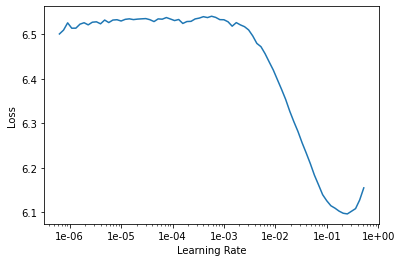

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.549628,4.401597,0.279975,13:04


In [0]:
learn.save('fit_head')

In [0]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(8, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.233065,4.201707,0.297007,13:11
1,4.198184,4.155815,0.303245,13:15
2,4.140989,4.123177,0.307257,13:15
3,4.092864,4.100599,0.310882,13:11
4,4.006413,4.088620,0.313115,13:18
5,3.937457,4.081835,0.314393,13:12
6,3.874592,4.081865,0.314993,13:13
7,3.831039,4.086341,0.314805,13:13


In [0]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "trump is a smart person"
N_WORDS = 15
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

trump is a smart person xxbos They 're obviously like Hawks , Hawks , Wings ,
trump is a smart person who needs the help of the Clinton campaign and can easily make the most


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [0]:
learn.save_encoder('fine_tuned_enc')

## Classifier

In [0]:
# loading classifier model data
data_clas = TextClasDataBunch.from_df(path, train_df=train, valid_df=valid, vocab=data_lm.vocab, bs=bs)

In [0]:
data_clas.show_batch()

text,target
xxbos * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc * * * * * * a mac is a xxup pc,0
"xxbos xxmaj you people are so racist . xxmaj you need to be more open minded like the xxmaj left . i am sure a multi - culture environment , moderate xxmaj muslims along with xxup love , xxup hugs xxup and xxup unicorns xxup and xxup rainbows xxup farting xxup out xxup of xxup our xxup ass will cause the xxmaj terrorist attacks to become xxunk xxmaj in fact",1
"xxbos xxmaj with such an impressive title as "" xxmaj white xxmaj guy who delivers xxmaj pizza , "" i 'm sure this individual has studied extensively on the subject , and his statements reflect his deep - understanding of the history of xxmaj africa xxunk proceeds xxmaj colonization , xxmaj slavery , the post - slavery prisoner - leasing program and the atrocious conditions for xxmaj african xxmaj americans",1
"xxbos xxmaj its almost as if we need a massive social program which allows us to provide housing to people at a price that they can afford ; there would have to be millions of houses though but maybe it would allow us to mitigate social problems such as class envy , class ignorance , and racial prejudice if we have unemployed people living next to plumbers next to doctors",1
"xxbos xxmaj mum used to tell us she was making "" a weird new dish tonight that i 've been wanting to try for a while "" xxmaj we were actually just to poor to go shopping and so she would have to cook with whatever was left in the pantry but she did n't want to worry us so she never said "" xxmaj this is all we have",0


We can then create a model to classify those comments and load the encoder we saved before.

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (808618 items)
x: TextList
xxbos xxmaj leicester was xxunk,xxbos xxmaj great argument !,xxbos ja maar je moet zeggen dat de islam slecht is anders ben je een dhimmi !,xxbos i suppose u need a decent base fund for that right ?,xxbos xxmaj tomorrow 's headline will be " xxmaj nintendo issues cease and desist notice to xxmaj majora 's xxmaj mask fan film . "
y: CategoryList
0,0,1,0,0
Path: /content/gdrive/My Drive/fastai-v3/data/sarcasm;

Valid: LabelList (202155 items)
x: TextList
xxbos xxmaj fool her twice , chicken soup and rice,xxbos * imitates motion * o xxrep 8 h,xxbos xxmaj naturally , they had the necessary two formal warnings and gave him the chance to rectify his behavior before they fired him , i presume ?,xxbos xxmaj yeah , you piece of shit .,xxbos xxmaj it might be a scam , i dunno .
y: CategoryList
0,0,1,0,0
Path: /content/gdrive/My Drive/fastai-v3/data/sarcasm;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(


In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


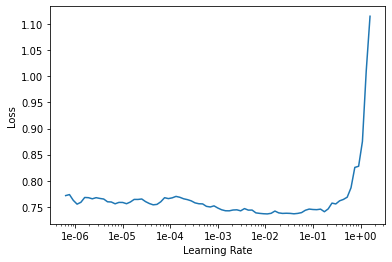

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.608223,0.582048,0.693260,11:42


In [0]:
learn.save('first')

In [0]:
learn.load('first');

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.545278,0.519652,0.743998,10:52


In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.516726,0.505005,0.755485,12:28


In [0]:
learn.save('third')

In [0]:
learn.load('third');

In [0]:
learn.freeze_to(-4)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.517758,0.495872,0.761351,12:48


In [0]:
learn.save('fourth')

In [0]:
learn.load('fourth');

In [0]:
learn.freeze_to(-5)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.501225,0.489952,0.764225,15:04


In [0]:
learn.save('fifth')

In [0]:
learn.load('fifth');

In [0]:
learn.freeze_to(-6)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.499836,0.488411,0.766298,14:28


In [0]:
learn.save('sixth')

In [0]:
learn.load('sixth');

In [0]:
learn.freeze_to(-7)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.486901,0.485912,0.767030,13:52


In [0]:
learn.save('seventh')

In [0]:
learn.load('seventh');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.470331,0.482084,0.770617,14:24
1,0.457233,0.479392,0.770943,14:34


Using this method, we are able to achieve an accuracy of about 0.771

In [0]:
learn.predict("this girl is smart")

(Category 0, tensor(0), tensor([0.5297, 0.4703]))

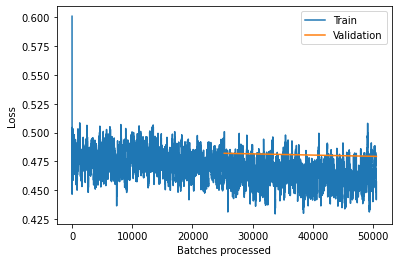

In [0]:
learn.recorder.plot_losses()

## Interpretation

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

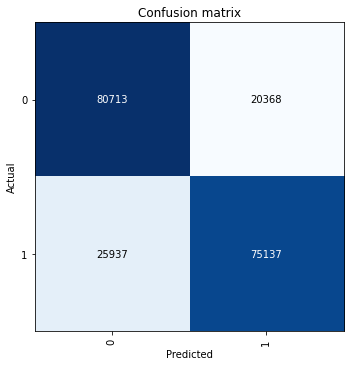

In [0]:
interp.plot_confusion_matrix(figsize=(5,5))

## Saving the model

In [0]:
model_path = str(path)+"/models/"
model_name = "model.pkl"

In [0]:
# exporting the final model
learn.export(model_path + model_name)

## Testing the Model with sample Data

In [0]:
learn = load_learner(model_path, model_name)

In [0]:
import pprint

def predict(str):
    pred_class,pred_idx,outputs = learn.predict(str)
    res =  zip (learn.data.classes, outputs.tolist())
    predictions = sorted(res, key=lambda x:x[1], reverse=True)
    top_predictions = predictions[0:2]
    pprint.pprint( top_predictions)

In [0]:
predict("Nice perfume. How long did you marinate in it?")

[(0, 0.8295121192932129), (1, 0.17048786580562592)]
